<h2 align=center> Facial Expression Recognition with Keras</h2>

In [1]:
cd D:\zzzzzzzzzzzzzzzzzzCoursera proj\facial image recognition

D:\zzzzzzzzzzzzzzzzzzCoursera proj\facial image recognition


In [2]:
pwd

'D:\\zzzzzzzzzzzzzzzzzzCoursera proj\\facial image recognition'

### Task 1: Import Libraries

In [3]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import utils
import os
%matplotlib inline

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

from IPython.display import SVG, Image
#from livelossplot import PlotLossesTensorFlowKeras
from livelossplot import PlotLossesKeras
from livelossplot.keras import PlotLossesCallback
import tensorflow as tf
print("Tensorflow version:", tf.__version__)

Tensorflow version: 2.1.0


Using TensorFlow backend.


### Task 2: Plot Sample Image

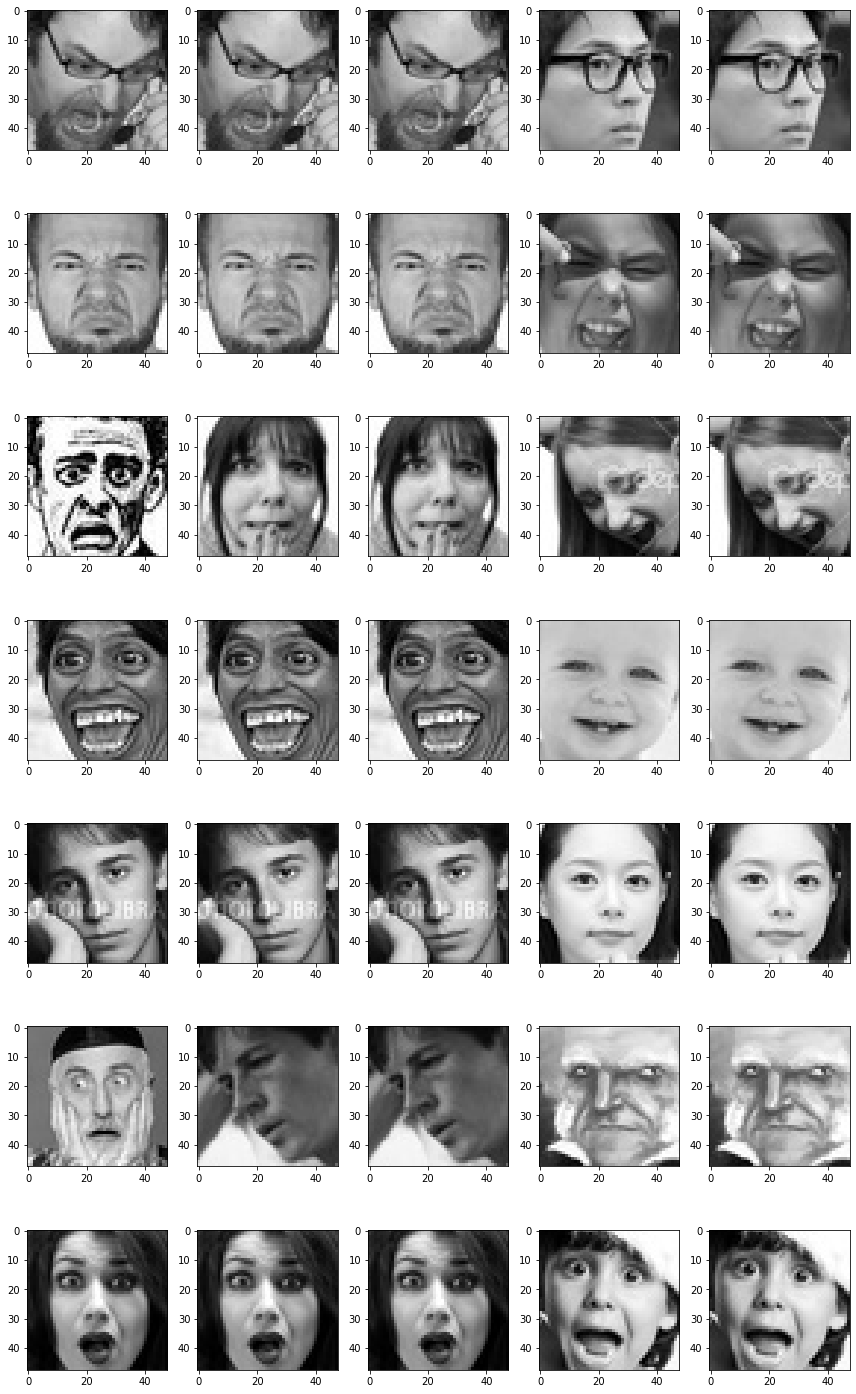

In [4]:
utils.datasets.fer.plot_example_images(plt).show()

In [5]:
# now lets see if we have a class imbalance problem 
#we look at the number of each type of faces in the dataset
# we can perform data augmentation to generate more images
# now lets see training set 

for expression in os.listdir("train/"):
    print(str(len(os.listdir("train/"+expression))) + " " + expression + "images" )

306 angryimages
390 disgustimages
188 fearimages
452 happyimages
292 neutralimages
206 sadimages
536 surpriseimages


### Task 3: Generate Training and Validation Batches

In [6]:
img_size= 48 #data contains 48*48 size images we set img size to be 48 
batch_size = 64 # to speed up the training process

# data generator for training set and validation set 

datagen_train = ImageDataGenerator(horizontal_flip=True)
train_generator = datagen_train.flow_from_directory("train/",
                                                    target_size=(img_size , img_size),
                                                    color_mode = 'grayscale',
                                                    batch_size = batch_size,
                                                    class_mode = 'categorical', 
                                                    shuffle = True )
datagen_validation = ImageDataGenerator(horizontal_flip=True)
validation_generator = datagen_train.flow_from_directory("test/",
                                                    target_size=(img_size , img_size),
                                                    color_mode = 'grayscale',
                                                    batch_size = batch_size,
                                                    class_mode = 'categorical', 
                                                    shuffle = True )

Found 2370 images belonging to 7 classes.
Found 2370 images belonging to 7 classes.


### Task 4: Create CNN Model

![](model.png)
Inspired by Goodfellow, I.J., et.al. (2013). Challenged in representation learning: A report of three machine learning contests. *Neural Networks*, 64, 59-63. [doi:10.1016/j.neunet.2014.09.005](https://arxiv.org/pdf/1307.0414.pdf)

In [7]:
# now the heart of the project that is to design the CNN model 

model = Sequential()
#1 -conv
model.add(Conv2D(64,(3,3),padding = 'same' , input_shape = (48,48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2))) # to decreasing the block size 
model.add(Dropout(0.25))

# 2-conv layer
model.add(Conv2D(128,(5,5),padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2))) # to decreasing the block size 
model.add(Dropout(0.25))

# 3-conv layer
model.add(Conv2D(512,(3,3),padding = 'same')) # window size 3,3
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2))) # to decreasing the block size 
model.add(Dropout(0.25))

# 4-conv layer
model.add(Conv2D(512,(3,3),padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2))) # to decreasing the block size 
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
# now this is our first fully connected layer 

model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(7 ,activation = 'softmax'))

# we use adam optimizer in this project

opt = Adam(lr = 0.0005)
model.compile(optimizer = opt , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 64)        640       
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 48, 48, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 128)       204928    
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 24, 128)       5

### Task 6: Train and Evaluate Model

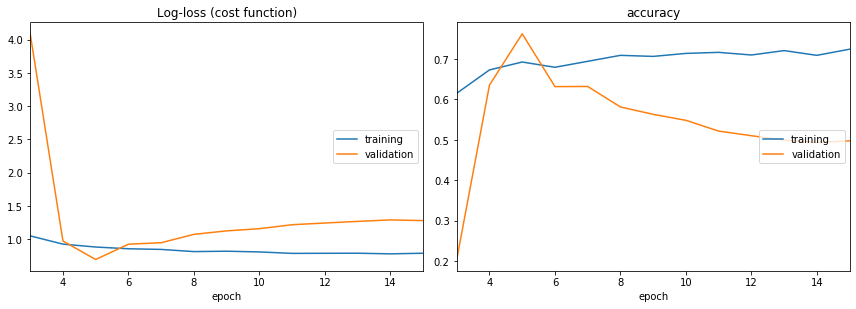

Log-loss (cost function):
training   (min:    0.779, max:    1.776, cur:    0.788)
validation (min:    0.694, max:    4.086, cur:    1.279)

accuracy:
training   (min:    0.395, max:    0.724, cur:    0.724)
validation (min:    0.204, max:    0.762, cur:    0.497)

Epoch 00015: saving model to model_weights.h5
37/37 [==============================] - 72s 2s/step - loss: 0.8488 - accuracy: 0.7238 - val_loss: 1.2787 - val_accuracy: 0.4975


In [8]:
epochs = 15 
steps_per_epoch = train_generator.n//train_generator.batch_size
validation_steps = validation_generator.n//validation_generator.batch_size

# define some callbacks 

checkpoint = ModelCheckpoint("model_weights.h5",monitor = 'val_accuracy',
                            save_weights_only = True , mode ='max' , verbose =1)

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss' ,factor = 0.1 , patience = 2 , min_lr = 0.00001 , model = 'auto')

callbacks = [PlotLossesCallback() , checkpoint , reduce_lr]

history = model.fit(
x = train_generator,
    steps_per_epoch = steps_per_epoch,
    epochs = epochs ,
    validation_data = validation_generator,
    validation_steps = validation_steps,
    callbacks = callbacks
)

### Task 7: Represent Model as JSON String

In [9]:
model_json = model.to_json()
with open("model.json","w") as json_file:
    json_file.write(model_json)

In [10]:
# we saved our model architecture by making it into a json file 
